This notebook shows TS plots with histogram frequency data. histxy command courtesy of Kyle.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

DIRECTORY = '/ocean/sallen/allen/research/Falkor/CTD_GG'

%matplotlib inline

In [2]:
def extract_quantities(line):
    index = np.int(line.partition(' ')[0])-1
    return index

In [3]:
def get_ctd_dat(fnm):
    QUANTITIES = {'Pressure': 'Pressure','Temperature':'Temperature:Primary','Transmissivity':'Tranmissivity',
                  'Fluorescence': 'Fluorescence','Turbidity':'Turbidity','Salinity':'Salinity:T',
                  'Oxygen':'Oxygen:Voltage'}

    index = {}

    f = open(os.path.join(DIRECTORY, fnm), 'rt')
    for line in f:
        line = line.strip()
        # look for start time
        if 'START TIME' in line:
            time = line.partition(' : ')[2]
        if line == '$TABLE: CHANNELS':
            break
    for line in f:
        line = line.strip()
        # find column listing
        for key, value in QUANTITIES.items():
            if value in line:
                index[key] = extract_quantities(line) 
        if line == '$TABLE: CHANNEL DETAIL':
#            print index
            break
    for line in f:
        line = line.strip()
        if 'LATITUDE' in line:
            latitude = line.partition(' : ')[2]
        if 'LONGITUDE' in line:
            longitude = line.partition(' : ')[2]        
        if 'STATION' in line:
            station = line.partition(': ')[2]
#            print station
        if line == '*CALIBRATION':
            break
    for line in f:
        line = line.strip()
        if '$END' in line:
            break
    for line in f:
        line = line.strip()
        words = line.split()
        delimiters = [len(w)+1 for w in words] 
        break
    thedata = np.genfromtxt(f,delimiter=delimiters, skiprows=7)
    thedata = thedata.transpose()
        
    return (thedata,index,station,latitude,longitude)

In [4]:
def hist2dxy(hist_x, hist_y, Xnum, Ynum, clevs, CMap='Spectral_r'):
    #Xlim=[np.nanmin(hist_x)-0.5, np.nanmax(hist_x)+0.5]
    Xlim=[31,35]
    Xbins=np.linspace(Xlim[0], Xlim[1], Xnum, dtype=np.float)
    #Ylim=[np.nanmin(hist_y)-0.5, np.nanmax(hist_y)+0.5]
    Ylim=[1,17]
    Ybins=np.linspace(Ylim[0], Ylim[1], Ynum, dtype=np.float)
    H, y_edges, x_edges = np.histogram2d(hist_y, hist_x, bins=(Ybins, Xbins))
    X, Y = np.meshgrid(x_edges[:-1], y_edges[:-1])
    # set axis
    left=0.1; width = 0.8; bottom=0.1; height = 0.65
    gap=0.02; hist_len=0.2; cbar_len=0.12
    # three boxes
    rect_main  = [left+hist_len+gap, bottom, width, height]
    rect_histx = [left+hist_len+gap, left+height+gap, width-cbar_len, hist_len]
    rect_histy = [left, bottom, hist_len, height]
    # x, y limits
    xlim_bin=[np.min(X), np.max(X)]
    ylim_bin=[np.min(Y), np.max(Y)]
    # ========== figure ========== #
    fig=plt.figure(figsize=(9, 9))
    # ========== Main ========== #
    # axis
    axMain=plt.axes(rect_main)
    axMain.yaxis.tick_right()
    axMain.yaxis.set_label_position('right')
    axMain.set_xlim(xlim_bin)
    axMain.set_ylim(ylim_bin)
    divider=make_axes_locatable(axMain)
    # grid and frame
    axMain.grid() # grid on
    [i.set_linewidth(2) for i in axMain.spines.itervalues()] # a bold frame
    CS=axMain.contourf(X, Y, H, clevs, cmap=CMap, extend='max') # 2-D histgram
    CAx=divider.append_axes('right', size='5%', pad=0.75)
    CBar=plt.colorbar(CS, cax=CAx)
    CBar.set_label('Number of points', fontsize=10)
    CBar.ax.tick_params(axis='y', length=22.5)
    # ========== Hist-x ========== #
    axHistx=plt.axes(rect_histx)
    axHistx.hist(hist_x, bins=Xbins, color='gray')
    axHistx.set_xlim(Xlim)
    axHistx.axes.get_xaxis().set_visible(False)
    # scientific notation for x, y-axis
    plt.ticklabel_format(style='sci', axis='both')#, scilimits=(0,0))
    [i.set_linewidth(2) for i in axHistx.spines.itervalues()]
    axHistx.grid()
    # ========== Hist-y ========== #
    axHisty = plt.axes(rect_histy)
    axHisty.hist(hist_y, bins=Ybins, color='gray', orientation='horizontal')
    axHisty.set_ylim(Ylim)
    axHisty.invert_xaxis()
    axHisty.axes.get_yaxis().set_visible(False)
    plt.ticklabel_format(style='sci', axis='both')#, scilimits=(0,0))
    [i.set_linewidth(2) for i in axHisty.spines.itervalues()]
    axHisty.grid()
    
    return axMain, axHistx, axHisty

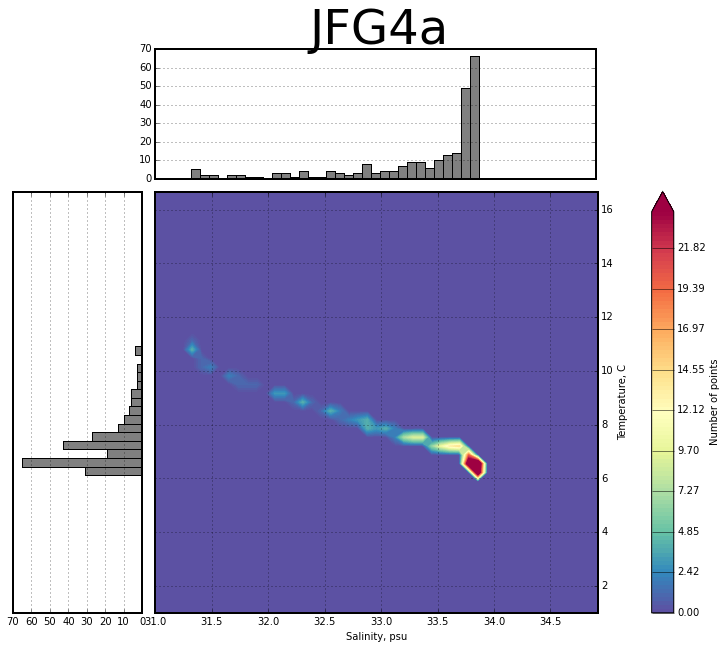

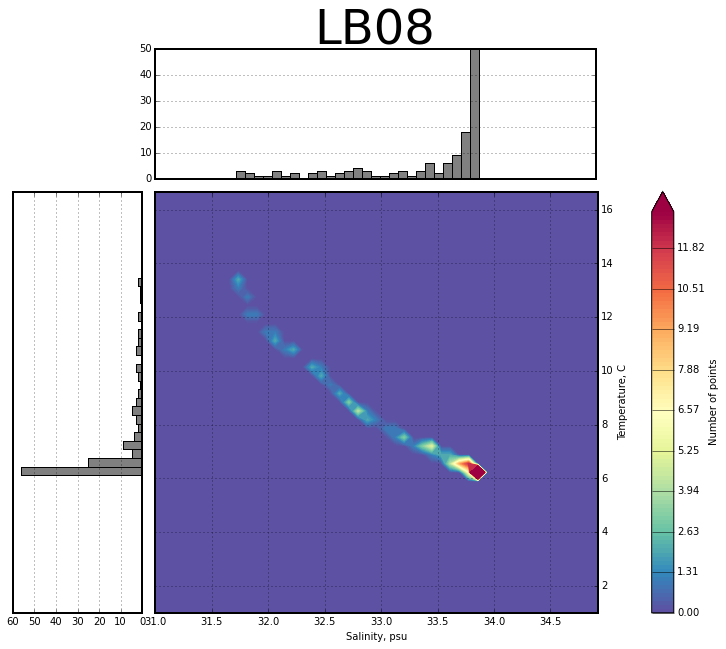

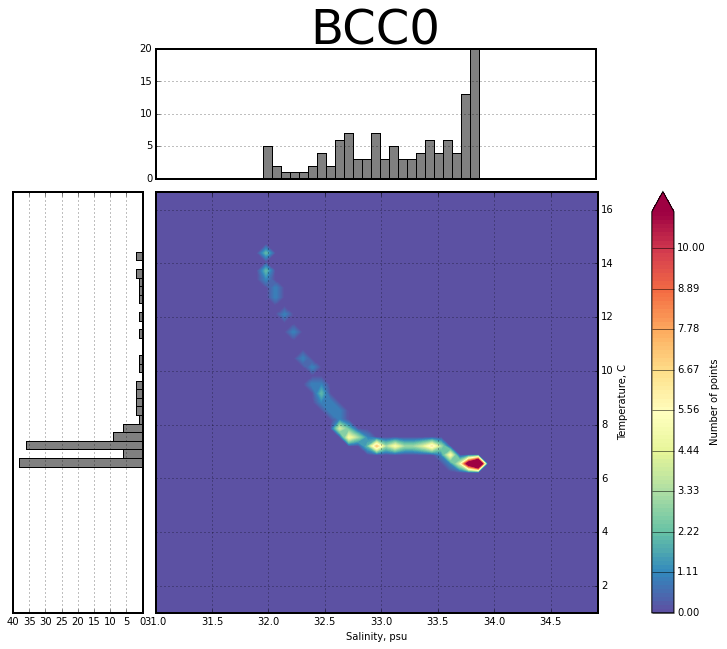

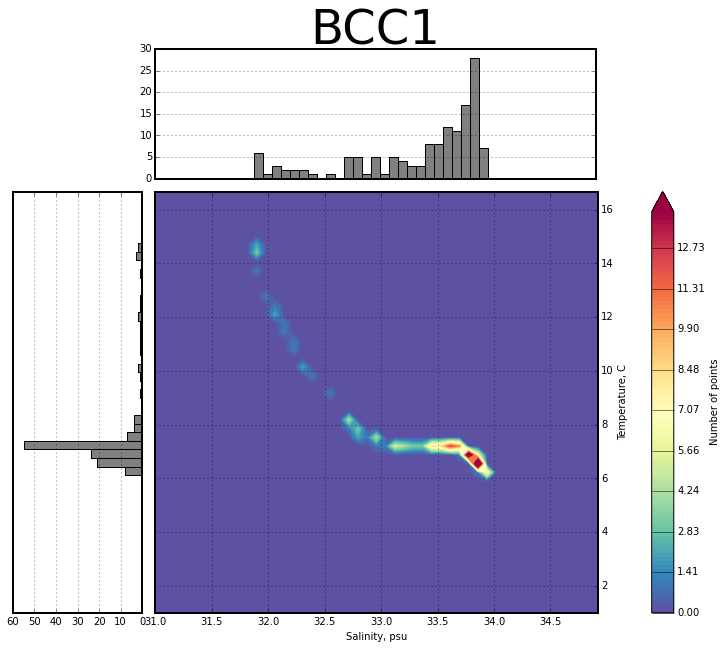

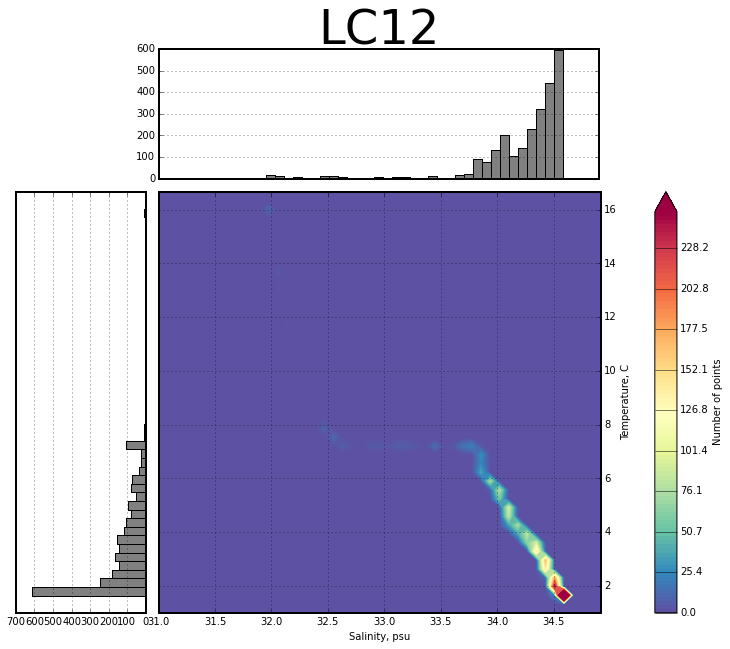

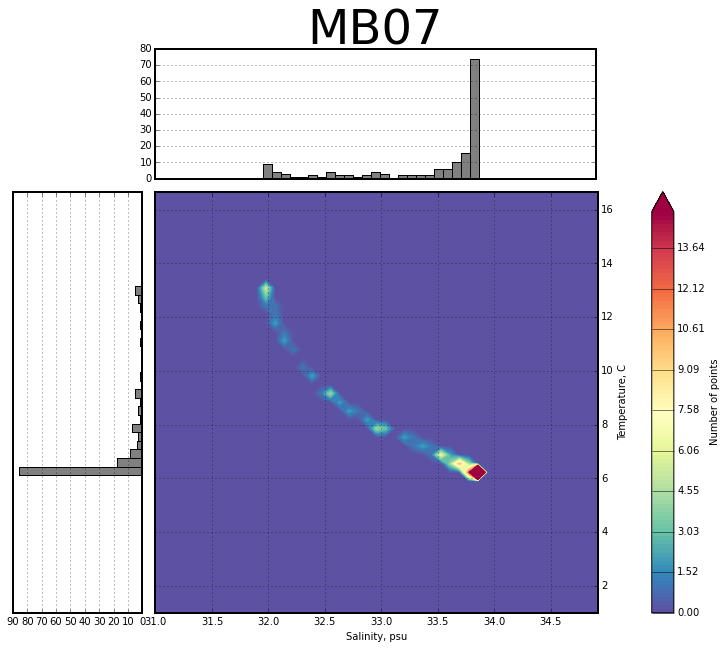

In [6]:
filenames = [f for f in os.listdir(DIRECTORY) if (f.startswith('2013-57-00') and f.endswith('avg'))]

for count,filename in enumerate(sorted(filenames)):
    thedata,index,station,lat,lon=get_ctd_dat(filename)
    
    #plt.subplot(3,3,count+1)
    Xhist_cnt = 50
    Yhist_cnt = 50
    max_cnt = len(thedata[index['Salinity'],:])/(Xhist_cnt/5)
    
    (axmain,axhistx,axhisty)=hist2dxy(thedata[index['Salinity'],:],thedata[index['Temperature'],:],Xhist_cnt,Yhist_cnt,np.linspace(0,1,100)*max_cnt)
    
    axhistx.set_title(station,fontsize=48)
    axmain.set_xlabel('Salinity, psu')
    axmain.set_ylabel('Temperature, C')
    plt.show()

Each profile shows a significant clustering of points near the densest water mass, suggesting that this particular water mass consitutes a significant portion of each water column.